In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
import networkx as nx
import matplotlib.pyplot as plt
from ase.io import read, write
import os
from topsearch.data.kinetic_transition_network import KineticTransitionNetwork
from topsearch.potentials.ml_potentials import MachineLearningPotential
from rdkit import Chem
from rdkit.Chem import rdDetermineBonds
import topsearch

from topsearch.plotting.stationary_points import plot_stationary_points
from topsearch.plotting.disconnectivity import plot_disconnectivity_graph
from topsearch.plotting.network import plot_network
import networkx as nx
from topsearch.plotting.network import barrier_reweighting
import numpy as np
from topsearch.similarity.molecular_similarity import MolecularSimilarity
from topsearch.data.coordinates import MolecularCoordinates
import pickle

In [40]:
def plot_network_diff(ktn, ktn_ml, dists, vs=[-0.01, 0.01], seed=42, sf=2, thresh=1.0, name='', colour_edges=False, dts=None):

        fig, axs = plt.subplots()
        colour_scheme='cool'

        g_weighted = barrier_reweighting(ktn)
        pos = nx.spring_layout(g_weighted, seed=seed, scale=1)
        colours = np.empty((0))

        ktn.G.remove_edges_from(nx.selfloop_edges(ktn.G))
        for i in ktn.G.nodes:
                colours = np.append(colours, ktn.G.nodes[i]['energy']-ktn.G.nodes[0]['energy'])

        network_contours = nx.draw_networkx_nodes(
                ktn.G, pos, node_color=colours, node_size=150,
                cmap=plt.get_cmap(colour_scheme), ax=axs, vmin=vs[0], vmax=vs[1])


        nx.draw_networkx_edges(ktn.G, pos, ax=axs, connectionstyle='arc3', node_size=150)
        cb = plt.colorbar(network_contours, label='Energy difference (eV)')
        np.random.seed(seed)
        pos_ml = {}
        skips=[]
        
        for i in dists:
                if i[2] > thresh:
                        skips.append(i[0])
                        continue
                d = np.random.rand(2)
                d = d/np.linalg.norm(d) * i[2] * sf
                print(f"Distance for {i}: {i[2]:5.3f}")
                
                de = ktn_ml.G.nodes[i[1]]['energy'] - ktn_ml.min_e + \
                        ktn.min_e - ktn.G.nodes[i[0]]['energy']
                print(f"Energy: {de:10.3f}")
                new_pos = [[pos[i[0]][0]+d[0]], [pos[i[0]][1]+d[1]]]
                pos_ml[i[1]] = new_pos
                
                if colour_edges:
                        axs.plot([new_pos[0][0], pos[i[0]][0]], 
                                 [new_pos[1][0], pos[i[0]][1]], 
                                 ls='-', c=dts[i], zorder=0.1, 
                                 cmap=network_contours.cmap, vmin=vs[0], vmax=vs[1])
                else:
                        axs.plot([new_pos[0][0], pos[i[0]][0]], 
                                 [new_pos[1][0], pos[i[0]][1]], 
                                 ls='-', c='tab:gray', zorder=0.1)

                axs.scatter(*new_pos, s=50, c=de, cmap=network_contours.cmap, 
                            vmin=vs[0], vmax=vs[1], zorder=10, edgecolors='k')

        for (i,j) in ktn.G.edges():
                if i in skips or j in skips:
                        continue    
                try:
                        i_n = dists[i][1]
                        j_n = dists[j][1]
                except:
                        continue
                if ktn_ml.G.has_edge(dists[i][1], dists[j][1]):
                        c='k'
                else:
                        c='r'
                axs.plot([pos_ml[i_n][0], pos_ml[j_n][0]], 
                         [pos_ml[i_n][1], pos_ml[j_n][1]], 
                         c=c, ls='--', zorder=0.01)
        
        axs.text(0.95, 0.95, name,
                        horizontalalignment='right',
                        verticalalignment='top',
                        transform = axs.transAxes,
                        fontsize=16)
        return fig, axs, cb
    

In [8]:
import os
os.environ['PATH'] += ':/u/jdm/.local/bin/x86_64-linux'

In [9]:
with open('/dccstor/aimft1/landscape_paper/analysis/analysis_ani_ethanol.pkl', 'rb') as f:
    ktn_eth, ktn_ml_eth, dists_eth, dists_2_eth, dat_eth = pickle.load(f)

In [24]:
def amalgamate_dat(dat):
    """Calculates aggregated statistics for table"""
    dats = [i[-1] for i in dat]
    d_m = np.mean(np.hstack([i[0] for i in dats]))
    d_ts = np.mean(np.hstack([i[1] for i in dats]))
    de_m = np.sqrt(np.mean(np.hstack([i[2] for i in dats])**2))
    print("Minima molecule breakdown: ", np.sqrt(np.hstack([np.mean([j**2 for j in i[2]]) for i in dats])))
    # print([i[3] for i in dats])
    # print([i[2] for i in dats])
    de_ts = np.sqrt(np.mean(np.hstack([i[3] for i in dats])**2))
    print("TS molecule breakdown: ", np.sqrt(np.hstack([np.mean([j**2 for j in i[3]]) for i in dats])))
    e_ts = [i[3] for i in dats]
    mp = np.sum(np.hstack([i[4] for i in dats]))
    mm = np.sum(np.hstack([i[5] for i in dats]))
    tp = np.sum(np.hstack([i[6] for i in dats]))
    tm = np.sum(np.hstack([i[7] for i in dats]))
    
    print(("Table data: " + (("{:5.3f} & "*2 + "{} & "*2)*2).format(d_m, de_m, mp, mm, d_ts, de_ts,  tp, tm))[:-3])
    return d_m, d_ts, de_m, e_ts, mp, mm, tp, tm

In [27]:
[i[-1][2] for i in nequip_dat]

[[-0.0002099999992424273, 0.0],
 [0.0],
 [0.00012000000060652383, 0.0],
 [0.19542999999976018,
  0.0,
  0.01735999999982596,
  -0.15551000000050408,
  -0.03629999999975553,
  0.06463000000076136]]

In [55]:
mace_dat = []
for i in ['ethanol', 'aspirin', 'paracetamol', 'salicylic']:
    # with open(f'/dccstor/aimft1/landscape_paper/analysis/analysis_mace_{i}_ase.pkl', 'rb') as f:
    # with open(f'/dccstor/aimft1/landscape_paper/analysis/analysis_mace_retrain_{i}.pkl', 'rb') as f:
    with open(f'/dccstor/aimft1/landscape_paper/analysis/analysis_mace_retrain_{i}_thresh1.pkl', 'rb') as f:
        mace_dat.append(pickle.load(f))

In [48]:
ani_dat = []
for i in ['ethanol', 'aspirin', 'paracetamol', 'salicylic']:
    # with open(f'/dccstor/aimft1/landscape_paper/analysis/analysis_ani_{i}_ase.pkl', 'rb') as f:
    with open(f'/dccstor/aimft1/landscape_paper/analysis/analysis_ani_ase_{i}_thresh1.pkl', 'rb') as f:
        ani_dat.append(pickle.load(f))

In [49]:
aim_dat = []
for i in ['ethanol', 'aspirin', 'paracetamol', 'salicylic']:
    # with open(f'/dccstor/aimft1/landscape_paper/analysis/analysis_aimnet_{i}_ase.pkl', 'rb') as f:
    with open(f'/dccstor/aimft1/landscape_paper/analysis/analysis_aimnet_ase_{i}_thresh1.pkl', 'rb') as f:
        aim_dat.append(pickle.load(f))

In [50]:
aimft_dat = []
for i in ['ethanol', 'paracetamol', 'salicylic']:
    # with open(f'/dccstor/aimft1/landscape_paper/analysis/analysis_aimnet_ft-3-sd-noreint_{i}_ase.pkl', 'rb') as f:
    with open(f'/dccstor/aimft1/landscape_paper/analysis/analysis_aimnet_ft-3-sd-noreint_ase_{i}_thresh1.pkl', 'rb') as f:
        aimft_dat.append(pickle.load(f))

In [51]:
nequip_dat = []
for i in ['ethanol', 'aspirin', 'paracetamol', 'salicylic']:
    with open(f'/dccstor/aimft1/landscape_paper/analysis/analysis_nequip_64_{i}_thresh1.pkl', 'rb') as f:
        nequip_dat.append(pickle.load(f))

In [52]:
allegro_dat = []
for i in ['ethanol', 'aspirin', 'paracetamol', 'salicylic']:
    with open(f'/dccstor/aimft1/landscape_paper/analysis/analysis_allegro_64_{i}_thresh1.pkl', 'rb') as f:
        allegro_dat.append(pickle.load(f))

In [53]:
d_m, _, de_m, d_ts_aimft, mp, mm, tp, tm = amalgamate_dat(aimft_dat)


Minima molecule breakdown:  [0.00371938 0.00535987 0.04875727]
TS molecule breakdown:  [0.01337           nan 0.03819008]
Table data: 0.098 & 0.039 & 3 & 1 & 0.140 & 0.034 & 5 & 9


/u/jdm/miniconda3/envs/aim/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/u/jdm/miniconda3/envs/aim/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [56]:
d_m, _, de_m, d_ts_mace, mp, mm, tp, tm = amalgamate_dat(mace_dat)


Minima molecule breakdown:  [9.89949494e-05 4.60630570e-01 5.58614357e-04 1.73700883e-01]
TS molecule breakdown:  [0.00015    0.09991           nan 0.09834251]
Table data: 0.152 & 0.225 & 14 & 9 & 0.370 & 0.090 & 5 & 13


In [57]:
d_m, _, de_m, d_ts_nequip, mp, mm, tp, tm = amalgamate_dat(nequip_dat)


Minima molecule breakdown:  [1.48492424e-04 0.00000000e+00 8.48528142e-05 1.06592950e-01]
TS molecule breakdown:  [0.00013           nan        nan 0.06547172]
Table data: 0.075 & 0.079 & 20 & 10 & 0.242 & 0.057 & 13 & 15


In [59]:
d_m, _, de_m, d_ts_allegro, mp, mm, tp, tm = amalgamate_dat(allegro_dat)

Minima molecule breakdown:  [7.77817459e-05 0.00000000e+00 6.36396100e-05 1.79223326e-01]
TS molecule breakdown:  [9.99999975e-06            nan 7.41035255e-05 9.44968057e-02]
Table data: 0.092 & 0.132 & 14 & 10 & 0.310 & 0.077 & 8 & 13


In [60]:
d_m, _, de_m, d_ts_ani, mp, mm, tp, tm = amalgamate_dat(ani_dat)

Minima molecule breakdown:  [0.00321734 0.         0.         0.01370776]
TS molecule breakdown:  [       nan        nan        nan 0.02503678]
Table data: 0.066 & 0.011 & 23 & 10 & 0.550 & 0.025 & 14 & 15


In [61]:
d_m, _, de_m, de_ts_aim, mp, mm, tp, tm = amalgamate_dat(aim_dat)

Minima molecule breakdown:  [0.0039103  0.         0.00504167 0.0668479 ]
TS molecule breakdown:  [0.02251         nan       nan 0.1143871]
Table data: 0.079 & 0.051 & 15 & 9 & 0.207 & 0.105 & 6 & 13



-------------------------------
Molecule: ethanol
-------------------------------
Distance for (0, 0, 0.0006616585517207825): 0.001
Energy:      0.000
Distance for (1, 1, 0.0011750036166249854): 0.001
Energy:      0.000

-------------------------------
Molecule: aspirin
-------------------------------
Distance for (0, 0, 0.17404852431648407): 0.174
Energy:      0.000

-------------------------------
Molecule: paracetamol
-------------------------------
Distance for (0, 0, 0.7196980110941334): 0.720
Energy:      0.000
Distance for (1, 1, 0.3438291133735808): 0.344
Energy:      0.000

-------------------------------
Molecule: salicylic
acid
-------------------------------
Distance for (0, 7, 0.11600016654138001): 0.116
Energy:     -0.309
Distance for (1, 0, 0.00076214870437588): 0.001
Energy:      0.000
Distance for (2, 2, 0.5329805000227584): 0.533
Energy:      0.206
Distance for (3, 4, 0.13838594445567248): 0.138
Energy:      0.152
Distance for (4, 5, 0.13661624271789172): 0.137
Energ

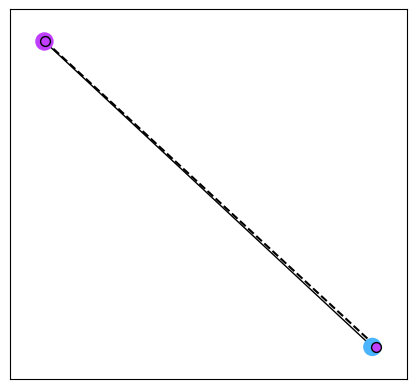

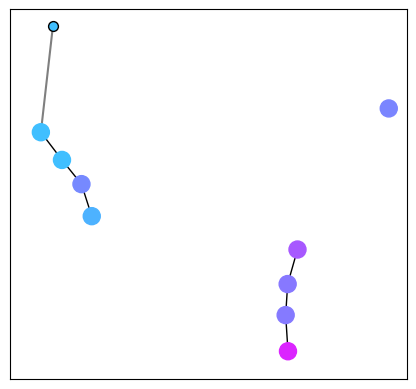

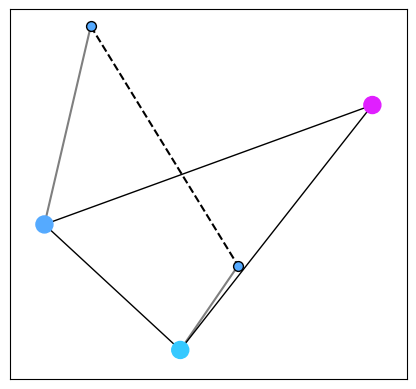

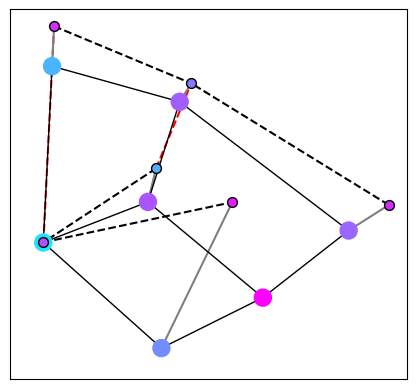

In [62]:
figs = []
vs = [[-0.015, 0.005],
      [-0.2, 0.6],
      [-0.05, 0.1],
      [-0.6, 0.3]]
names=['ethanol', 'aspirin', 'paracetamol', 'salicylic\nacid', ]
names2=['ethanol', 'aspirin', 'paracetamol', 'salicylic', ]
for i in range(4):
    print(f"\n-------------------------------\nMolecule: {names[i]}\n-------------------------------")
    fig, axs, cb = plot_network_diff(*allegro_dat[i][:3], seed=43, thresh=1.5, vs=vs[i], name='', 
                                 colour_edges=False, dts=d_ts_allegro)
    
    cb.ax.set_visible(False)
    plt.draw()
    figs.append(fig)
    fig.savefig(f'allegro-{names2[i]}-nocb.png', dpi=200)
    

Distance for (0, 1, 0.0007828509215727119): 0.001
Energy:      0.000
Distance for (1, 0, 0.0028219252922967093): 0.003
Energy:      0.000
Distance for (0, 5, 0.1388700195244542): 0.139
Energy:      0.000
Distance for (0, 0, 0.7003997944429804): 0.700
Energy:     -0.000
Distance for (1, 1, 0.055124885312095556): 0.055
Energy:      0.000
Distance for (0, 3, 0.038214656437960765): 0.038
Energy:     -0.195
Distance for (1, 0, 0.0008039571176345715): 0.001
Energy:      0.000
Distance for (2, 1, 0.5319928396074461): 0.532
Energy:     -0.017
Distance for (3, 5, 0.1279104141701505): 0.128
Energy:      0.156
Distance for (4, 6, 0.09465360622907747): 0.095
Energy:      0.036
Distance for (5, 4, 0.0717917044688849): 0.072
Energy:     -0.065


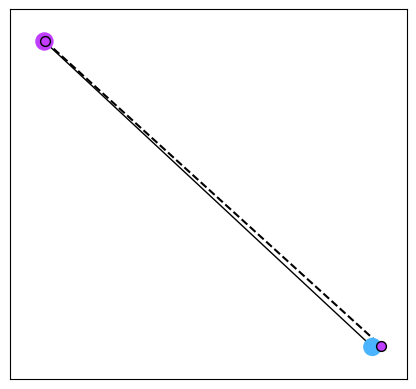

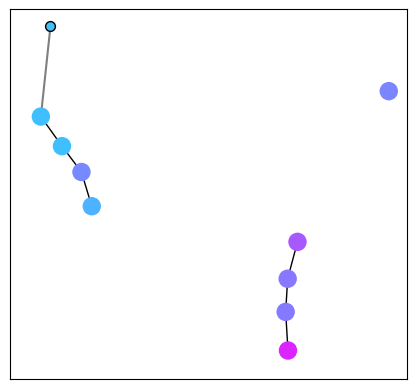

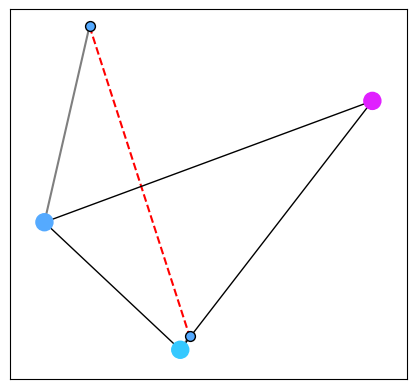

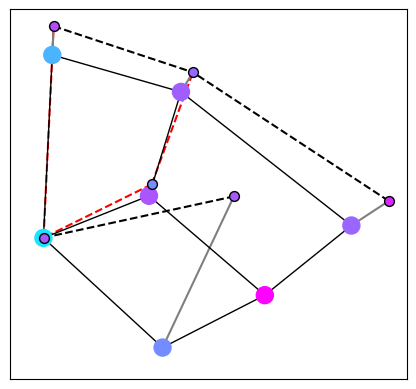

In [63]:
figs = []
vs = [[-0.015, 0.005],
      [-0.2, 0.6],
      [-0.05, 0.1],
      [-0.6, 0.3]]
names=['ethanol', 'aspirin', 'paracetamol', 'salicylic\nacid', ]
names2=['ethanol', 'aspirin', 'paracetamol', 'salicylic', ]
for i in range(4):
    fig, axs, cb = plot_network_diff(*nequip_dat[i][:3], seed=43, thresh=1.5, vs=vs[i], name='', 
                                 colour_edges=False, dts=d_ts_nequip)
    
    cb.ax.set_visible(False)
    plt.draw()
    figs.append(fig)
    fig.savefig(f'nequip-{names2[i]}-nocb.png', dpi=200)
    

Distance for (0, 1, 0.021648001532798864): 0.022
Energy:     -0.006
Distance for (1, 0, 0.052367667702053124): 0.052
Energy:      0.000
Distance for (0, 0, 0.8018646596045987): 0.802
Energy:      0.000
Distance for (0, 1, 0.31270492759663465): 0.313
Energy:     -0.007
Distance for (1, 2, 0.18311728194961027): 0.183
Energy:      0.000
Distance for (0, 3, 0.041148743138490526): 0.041
Energy:     -0.053
Distance for (1, 0, 0.055143233580131235): 0.055
Energy:      0.000
Distance for (2, 1, 0.1058106372946505): 0.106
Energy:     -0.095
Distance for (3, 7, 0.06158613159585456): 0.062
Energy:     -0.054
Distance for (4, 2, 0.03941462393456681): 0.039
Energy:     -0.004
Distance for (5, 6, 0.057006723643718386): 0.057
Energy:     -0.047
Distance for (6, 4, 0.3780966330603723): 0.378
Energy:     -0.120


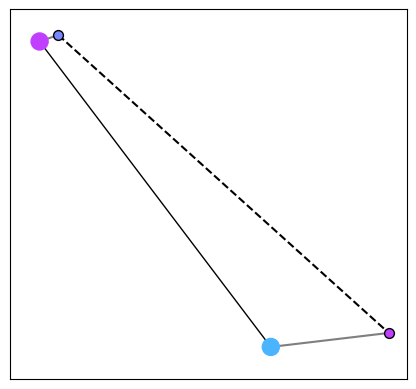

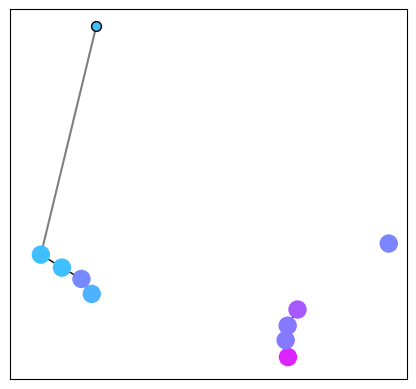

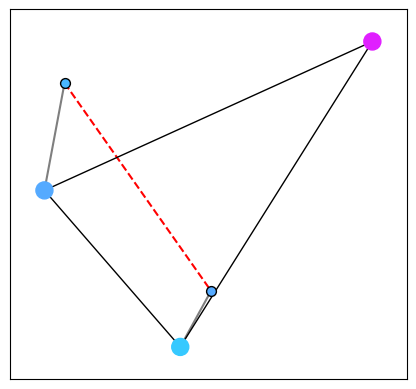

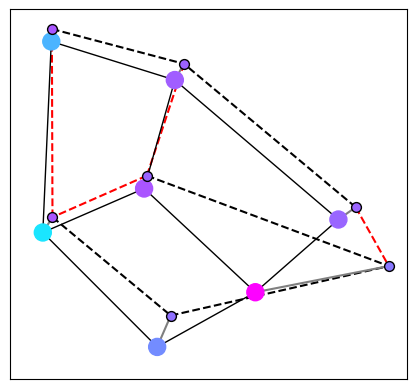

In [64]:
figs = []
vs = [[-0.015, 0.005],
      [-0.2, 0.6],
      [-0.05, 0.1],
      [-0.6, 0.3]]
names=['ethanol', 'aspirin', 'paracetamol', 'salicylic\nacid', ]
names2=['ethanol', 'aspirin', 'paracetamol', 'salicylic', ]
for i in range(4):
    fig, axs, cb = plot_network_diff(*aim_dat[i][:3], seed=43, thresh=1.5, vs=vs[i], name='', 
                                 colour_edges=False, dts=de_ts_aim)
    
    cb.ax.set_visible(False)
    plt.draw()
    figs.append(fig)
    fig.savefig(f'aim-{names2[i]}-nocb.png', dpi=200)
    

Distance for (0, 1, 0.010798573771303189): 0.011
Energy:     -0.005
Distance for (1, 0, 0.04831403459162251): 0.048
Energy:      0.000
Distance for (0, 2, 0.7928912379477728): 0.793
Energy:      0.000
Distance for (0, 3, 0.22641317490138269): 0.226
Energy:      0.000
Distance for (0, 1, 0.011003131805158118): 0.011
Energy:      0.009
Distance for (1, 0, 0.014928959386487398): 0.015
Energy:      0.000
Distance for (2, 4, 0.18891112851383532): 0.189
Energy:      0.010
Distance for (3, 3, 0.01457170993322201): 0.015
Energy:      0.009
Distance for (4, 5, 0.052339680651830776): 0.052
Energy:      0.023
Distance for (5, 2, 0.025055400910504767): 0.025
Energy:      0.002
Distance for (6, 6, 0.05219631856010142): 0.052
Energy:      0.023


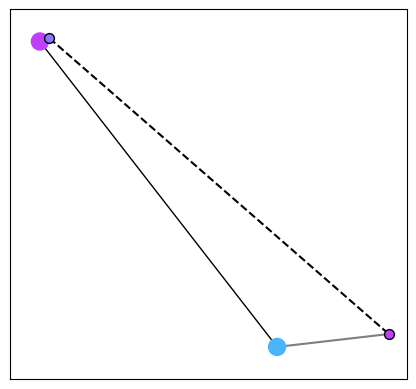

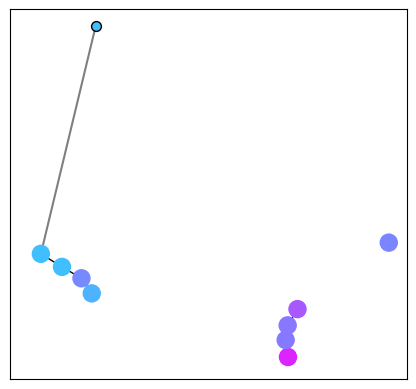

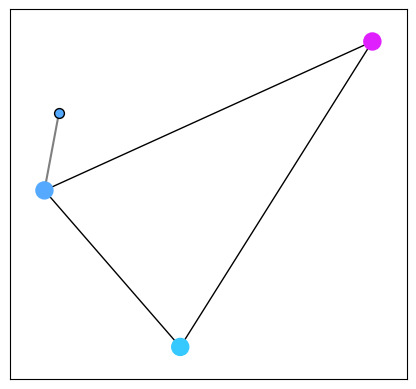

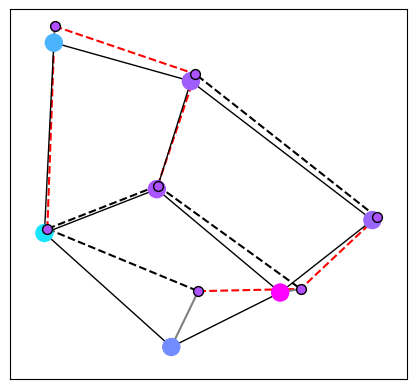

In [65]:
figs = []
vs = [[-0.015, 0.005],
      [-0.2, 0.6],
      [-0.05, 0.1],
      [-0.6, 0.3]]
names=['ethanol', 'aspirin', 'paracetamol', 'salicylic\nacid', ]
names2=['ethanol', 'aspirin', 'paracetamol', 'salicylic', ]

for i in range(4):
      
    fig, axs, cb = plot_network_diff(*ani_dat[i][:3], seed=43, vs=vs[i], name='')
    
    cb.ax.set_visible(False)
    plt.draw()
    figs.append(fig)
    fig.savefig(f'ani-{names2[i]}-nocb.png', dpi=200)
    

Distance for (0, 1, 0.0004702304376939439): 0.000
Energy:      0.000
Distance for (1, 0, 0.0029184092044773724): 0.003
Energy:      0.000


Distance for (0, 0, 0.19161718078842932): 0.192
Energy:      0.000
Distance for (4, 2, 0.9559081582232115): 0.956
Energy:      0.651
Distance for (0, 0, 0.6864358914451284): 0.686
Energy:     -0.001
Distance for (1, 3, 0.09660027754770606): 0.097
Energy:      0.000
Distance for (0, 3, 0.12502826928224833): 0.125
Energy:     -0.288
Distance for (1, 0, 0.0008621220600550938): 0.001
Energy:      0.000
Distance for (2, 2, 0.5716848588801611): 0.572
Energy:      0.088
Distance for (3, 4, 0.14395355796302994): 0.144
Energy:      0.263
Distance for (4, 1, 0.11612404642616922): 0.116
Energy:      0.107
Distance for (5, 5, 0.1259317368787831): 0.126
Energy:     -0.097


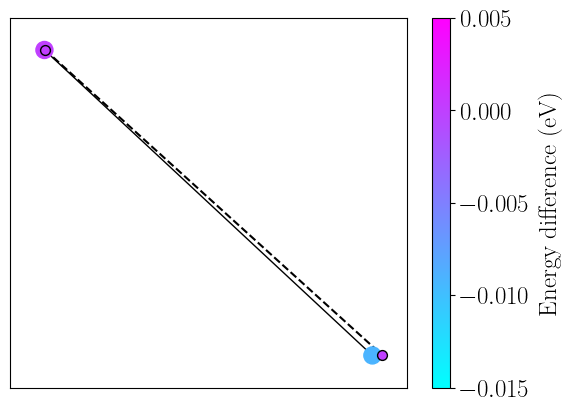

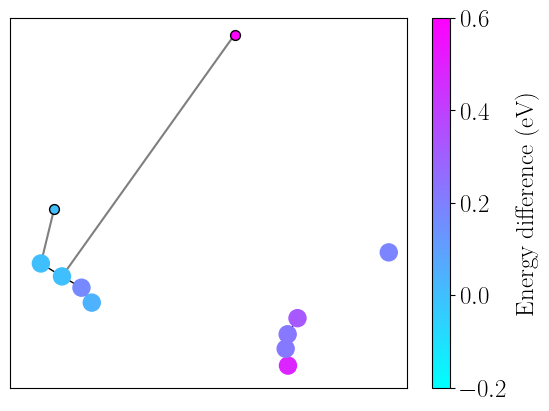

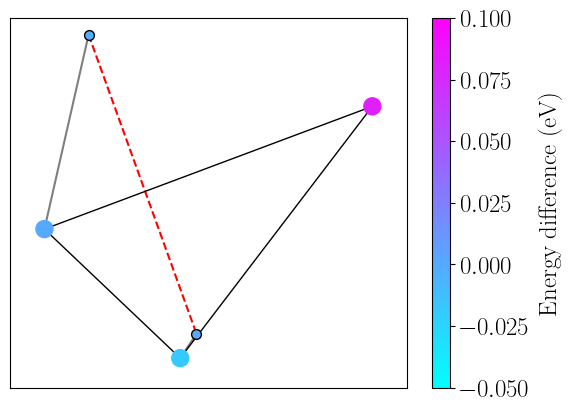

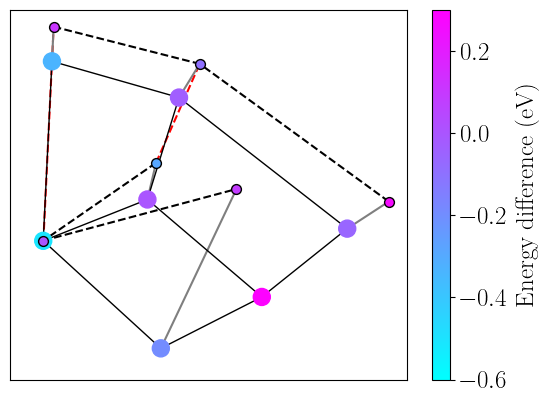

In [66]:
figs = []
vs = [[-0.015, 0.005],
      [-0.2, 0.6],
      [-0.05, 0.1],
      [-0.6, 0.3]]
names=['ethanol', 'aspirin', 'paracetamol', 'salicylic\nacid', ]
names2=['ethanol', 'aspirin', 'paracetamol', 'salicylic', ]

for i in range(4):
    fig, axs, cb = plot_network_diff(*mace_dat[i][:3], seed=43, vs=vs[i], 
                              #    name=names[i])
                                 name='')
    figs.append(fig)
    fig.savefig(f'mace-{names2[i]}-nocb.png', dpi=200)